In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import matplotlib.pyplot as plt

In [4]:
from eclyon.transforms import process_df, split_vals

In [5]:
path_to_repo = Path('..').resolve()
path_to_data = path_to_repo / 'data'

In [6]:
df= pd.read_csv(path_to_data / 'clean_health.csv')
df

,gender,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,smoker,drinker
0,True,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1,1
1,True,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3,0
2,True,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1,0
3,True,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1,0
4,True,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991341,True,45,175,80,92.1,1.5,1.5,1.0,1.0,114.0,...,125.0,132.0,15.0,1.0,1.0,26.0,36.0,27.0,1,0
991342,True,35,170,75,86.0,1.0,1.5,1.0,1.0,119.0,...,84.0,45.0,15.8,1.0,1.1,14.0,17.0,15.0,1,0
991343,False,40,155,50,68.0,1.0,0.7,1.0,1.0,110.0,...,77.0,157.0,14.3,1.0,0.8,30.0,27.0,17.0,3,1
991344,True,25,175,60,72.0,1.5,1.0,1.0,1.0,119.0,...,73.0,53.0,14.5,1.0,0.8,21.0,14.0,17.0,1,0


In [7]:
df, y, nas = process_df(df,'drinker')

In [8]:
print(len(df))

991346


We will use around 90% of the dataset as training data and 10% for validation

In [9]:
n_total = len(df)
n_valid = 12000
n_train = n_total - n_valid
n_small = 20000

X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small, _ = split_vals(df, n_small)
y_small, _ = split_vals(y, n_small)

y_train = y_train.tolist()
y_valid = y_valid.tolist()
y_small = y_small.tolist()

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, len(y_small)))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, len(y_train)))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, len(y_valid)))

Number of small training data points: X = (20000, 23), y = 20000
Number of full training data points: X = (979346, 23), y = 979346
Number of validation data points: X = (12000, 23), y = 12000


I will use CatBoostClassifier to fit my model. First testing it with my small dataset

In [10]:
model_small = CatBoostClassifier(
    n_estimators = 5000,  
    learning_rate = 0.001, 
    random_seed = 42,
    allow_writing_files = False,
    logging_level = 'Silent',
)

In [11]:
model_small.fit(X_small, y_small)
print(model_small.score(X_valid, y_valid)) # classification accuracy on small set

0.73025


The result is already quite good, I will use a grid search to try to find the optimal parameters for the model

In [12]:
param_grid = [
    {'learning_rate': [0.01],
     'depth'         : [4],
    'iterations'    : [2000]
    }]

    
model = CatBoostClassifier(
    random_state = 42, 
    silent = True
    
)

# I cannot run the whole param grid because my computer crashes, I change up the values to see various results 

In [13]:
tuned_model = GridSearchCV(
    estimator = model, 
    param_grid = param_grid, 
    scoring = None, # uses estimator's default score method 
    refit = True, # keep a fitted version of the overall best model
    cv = 5
)

In [14]:
tuned_model.fit(X_small, y_small)


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x145878910>,
             param_grid=[{'depth': [4], 'iterations': [2000],
                          'learning_rate': [0.01]}])

In [15]:
print(tuned_model.best_params_)
print(tuned_model.best_score_)

{'depth': 4, 'iterations': 2000, 'learning_rate': 0.01}
0.73375


Since the dataset is quite big, my computer is not able to perform a big grid search, here are a few indidual grid searches I have performed to find the best one. 

- {'depth': 3, 'iterations': 1000, 'learning_rate': 0.01}

  score = 0.7313000000000001

- {'depth': 3, 'iterations': 2000, 'learning_rate': 0.01}

  score = 0.7321

- {'depth': 4, 'iterations': 2000, 'learning_rate': 0.01}

    score = 0.73375

In [16]:
param_grid = [
    {'learning_rate': [0.01],
     'depth'         : [4],
    'iterations'    : [2000],
     'l2_leaf_reg' : [5, 10, 20],
    'random_strength': [1,5, 10],
     
    }]

    
model = CatBoostClassifier(
    random_state = 42,
    silent = True
)

In [17]:
tuned_model = GridSearchCV(
    estimator = model, 
    param_grid = param_grid, 
    scoring = None, # uses estimator's default score method 
    refit = True, # keep a fitted version of the overall best model
    cv = 5
)

In [ ]:
tuned_model.fit(X_small, y_small)

In [ ]:
print(tuned_model.best_params_)
print(tuned_model.best_score_)

In [20]:
def specificity_score(y_true, y_predict):
    '''
    Computes the proba that a label is 0 knowing that the prediction is 0
    '''
    y_predict_0  = [(pred, true) for pred, true in zip(y_predict, y_true) if true == 0]
    y_predict_00 = [(pred, true) for pred, true in y_predict_0 if pred == 0]
    specificity  = (0 if len(y_predict_0) == 0 else len(y_predict_00)/len(y_predict_0))
    return specificity

Let's see the scores of the first model of the small dataset

In [21]:
y_predict_small = model_small.predict(X_valid)

acc = metrics.accuracy_score(y_valid, y_predict_small)
rec = metrics.recall_score(y_valid, y_predict_small)
prc = metrics.precision_score(y_valid, y_predict_small)
spe = specificity_score(y_valid, y_predict_small)
f1  = metrics.f1_score(y_valid, y_predict_small)

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

Accuracy : 73.02%
Recall : 73.44%
Precision : 72.97%
Specificity : 72.60%
F1-score : 73.21%


The scores of the tuned model on the small dataset

In [22]:
y_predict_small = tuned_model.predict(X_valid)

acc = metrics.accuracy_score(y_valid, y_predict_small)
rec = metrics.recall_score(y_valid, y_predict_small)
prc = metrics.precision_score(y_valid, y_predict_small)
spe = specificity_score(y_valid, y_predict_small)
f1  = metrics.f1_score(y_valid, y_predict_small)

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

Accuracy : 73.56%
Recall : 73.94%
Precision : 73.51%
Specificity : 73.17%
F1-score : 73.73%


In [23]:
y_hat_boost = tuned_model.predict(X_valid)
confusion = metrics.confusion_matrix(y_hat_boost, y_valid)
print("confusion table of tuned model")
print(confusion)


confusion table of tuned model
[[4375 1569]
 [1604 4452]]


In [11]:
model_full = CatBoostClassifier(
    n_estimators = 2000, 
    learning_rate = 0.01,
    depth = 4,
    random_strength = 5,  
    l2_leaf_reg = 5,
    random_seed = 42,
    allow_writing_files = False,
    logging_level = 'Silent',
)

In [12]:
model_full.fit(X_train, y_train)
print(model_full.score(X_valid, y_valid)) # classification accuracy on full set

0.7385833333333334


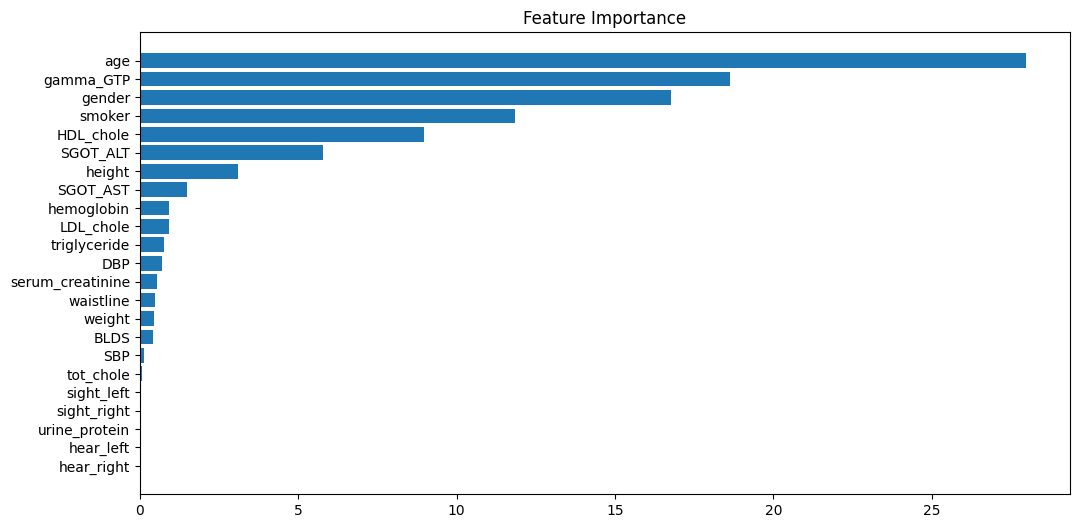

In [23]:
#added feature importance
feature_importance = model_full.feature_importances_
sorted = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted)), feature_importance[sorted])
plt.yticks(range(len(sorted)), np.array(X_valid.columns)[sorted])
plt.title('Feature Importance')
plt.show()

In [43]:
y_predict_valid = model_full.predict(X_valid)

acc = metrics.accuracy_score(y_valid, y_predict_valid)
rec = metrics.recall_score(y_valid, y_predict_valid)
prc = metrics.precision_score(y_valid, y_predict_valid)
spe = specificity_score(y_valid, y_predict_valid)
f1  = metrics.f1_score(y_valid, y_predict_valid)

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

Accuracy : 73.86%
Recall : 74.62%
Precision : 73.63%
Specificity : 73.09%
F1-score : 74.12%


In [44]:
model_full.save_model(path_to_repo / 'models' / "model_tuned",
           format="cbm",
           export_parameters=None,
           pool=None)